In [13]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplot
from sklearn.metrics import log_loss
from sklearn.linear_model import Lasso
import utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

In [2]:
df=pd.read_csv("airline_train.csv")

encoder=LabelEncoder()
df['Customer Type Enc']=encoder.fit_transform(df["Customer Type"])
df['Type of Travel Enc']=encoder.fit_transform(df["Type of Travel"])
df['Gender Enc']=encoder.fit_transform(df["Gender"])
df['Class Enc']=encoder.fit_transform(df["Class"])
df['Target']=encoder.fit_transform(df["satisfaction"])
df.drop(["Customer Type","Type of Travel","Gender","Class","Unnamed: 0","satisfaction"],inplace=True,axis=1)
df.set_index("id",inplace=True)
#,"Type of Travel","Inflight wifi service"]])
print(df.columns)
print(df)

decimal_cols=["Age","Flight Distance"]
for col in decimal_cols:
    df[col] = df[col].fillna(df[col].mean())

other_cols=[x for x in df.columns if not x in decimal_cols]
for col in other_cols:    
    df[col] = df[col].fillna(df[col].value_counts().index[0])
 


Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Customer Type Enc', 'Type of Travel Enc', 'Gender Enc', 'Class Enc',
       'Target'],
      dtype='object')
        Age  Flight Distance  Inflight wifi service  \
id                                                    
70172    13              460                      3   
5047     25              235                      3   
110028   26             1142                      2   
24026    25              562                      2   
119299   61              214                      3   
...     ...              ...                    ...   
94171    23        

In [3]:
X_Columns=  [x for x in df.columns if x!="Target"]
X=df[X_Columns]
y=df["Target"]
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.1,random_state=42)

In [4]:
pipeline= Pipeline([
   ('scaler',StandardScaler()),
    ('pca', PCA()),
    ('clf',LogisticRegression(max_iter=10000,C=5)
   )
])
pipeline.fit(X_train,y_train)
log_reg_clf=pipeline['clf']
log_reg_clf.fit(X_train,y_train)

LogisticRegression(C=5, max_iter=10000)

In [5]:
predictions=log_reg_clf.predict(X_test)

lr_test_accuracy=accuracy_score(y_test, predictions)
print("Accuracy={}, Precision={}, Recall={}".format(accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions)))

    
original_variables=list(X_train.columns)

zipped_together=list(zip(original_variables,log_reg_clf.coef_[0]))
coefs = [list(x) for x in zipped_together]

coefs=pd.DataFrame(coefs, columns=['Variable','Coefficient'])


coefs.sort_values(by=['Coefficient'], axis=0, inplace=True, ascending=False)

print(coefs)

Accuracy=0.8756616302569531, Precision=0.8756103231806557, Recall=0.8326332080477559
                             Variable  Coefficient
7                     Online boarding     0.617493
2               Inflight wifi service     0.385447
13                    Checkin service     0.321797
10                   On-board service     0.306363
11                   Leg room service     0.255223
15                        Cleanliness     0.221493
12                   Baggage handling     0.136000
14                   Inflight service     0.129656
8                        Seat comfort     0.068588
20                         Gender Enc     0.051289
9              Inflight entertainment     0.044316
5                       Gate location     0.029937
16         Departure Delay in Minutes     0.003886
1                     Flight Distance    -0.000008
0                                 Age    -0.008626
17           Arrival Delay in Minutes    -0.008714
6                      Food and drink    -0.0157

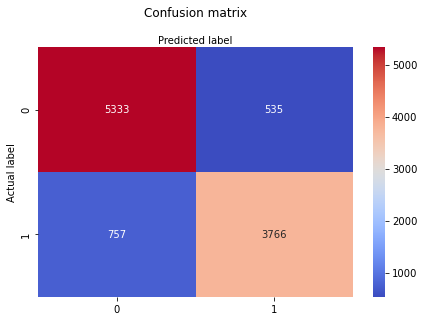

In [6]:
y_pred=pipeline['clf'].predict(X_test)

cm = confusion_matrix(y_test,y_pred)

class_names=[1,2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()



In [ ]:
#g=sns.JointGrid(data=df, x='Online boarding', y='On-board service')
print("Online boarding is important")
g=sns.JointGrid(data=df, x='Online boarding', y='Target')
g=g.plot_joint(sns.kdeplot)
g=g.plot_marginals(sns.kdeplot, shade=True)
plt.show()

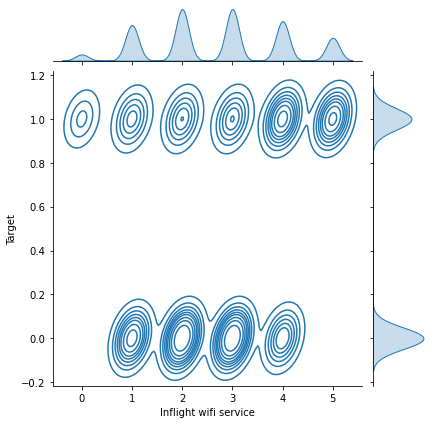

In [90]:
print("Generall wifi service was important")
g=sns.JointGrid(data=df, x='Inflight wifi service', y='Target')
g=g.plot_joint(sns.kdeplot)
g=g.plot_marginals(sns.kdeplot, shade=True)
plt.show()

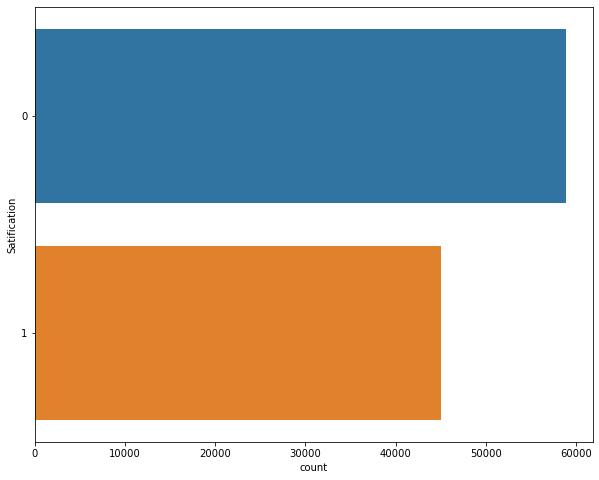

In [86]:
plt.figure(figsize=(10,8))
X2=pd.DataFrame()
X2['Target']=df['Target']
sns.countplot(data=X2, y="Target")
plt.ylabel("Satification")
plt.show()

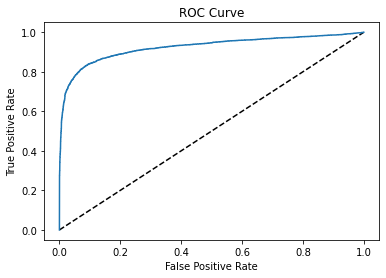

In [105]:
def my_loss(y,w):
    s = 0
    for i in range(y.size):
        # Get the true and predicted target values for example 'i'
        y_i_true = y[i]
        y_i_pred = w[i]
        s = s + (y_i_true - y_i_pred)**2
    return s

#print("Loss:",my_loss(y_test,y_pred))
y_pred_prob=pipeline['clf'].predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



In [114]:
loss = log_loss(y_test, y_pred_prob)
print("Log Loss is %s",loss)

Log Loss is %s 0.3380643894733441


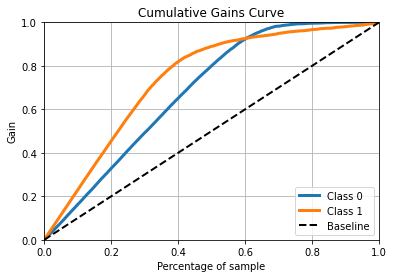

In [110]:
#predictions=lr.predict(X_test)
predictions=pipeline['clf'].predict_proba(X_test)

skplot.metrics.plot_cumulative_gain(y_true=y_test, y_probas=predictions)
plt.show()

In [116]:
pipeline2= Pipeline([
    ('scaler',StandardScaler()),
    ('clf',RandomForestClassifier(n_estimators=400,max_depth=8)),
])

pipeline2['clf'].fit(X_train,y_train)

predictions=pipeline2['clf'].predict(X_test)

print("Random forest Model accuracy {}%".format(accuracy_score(y_test,predictions)*100))



Model accuracy 93.80232893850447%


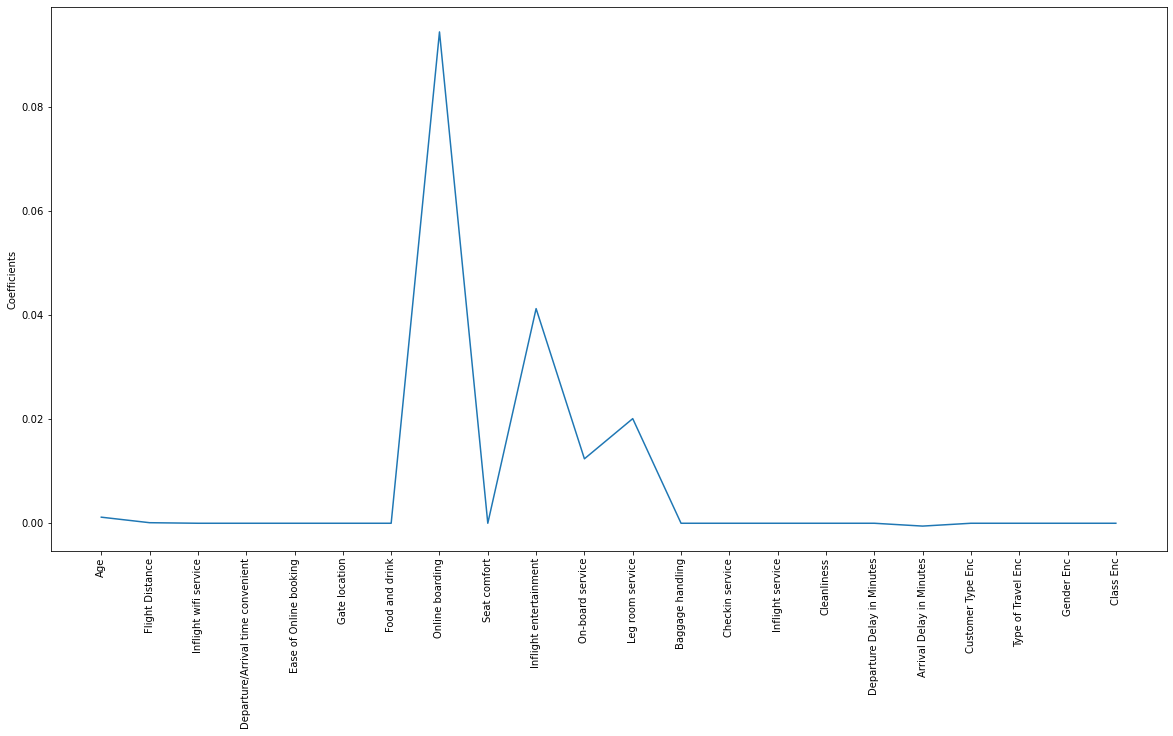

Online boarding and Leg room and entertainment are important


In [137]:
lasso=Lasso(alpha=0.1)
lasso_coef=lasso.fit(X_train,y_train).coef_
names=[x for x in df.columns if x!='Target']
fig,ax=plt.subplots(figsize=(20,10))
_ = ax.plot(range(len(names)),lasso_coef)
_ = plt.xticks(range(len(names)),names,rotation=90)
_ = plt.ylabel('Coefficients')
plt.show()

print("Online boarding and Leg room and entertainment are important")

In [10]:
def plot_scatter(model, X_train_pca,y_train, X_test_pca,y_test, title=None, figsize=(10, 10)):
    """
    Plot the decision boundary of a logistic regression model.
    """
    
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

    xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))

    Z_train = model.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
    Z_train = Z_train.reshape(xx_train.shape)


    x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
    y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1

    xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))

    Z_test = model.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
    Z_test = Z_test.reshape(xx_test.shape)
    
    plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.contourf(xx_train, yy_train, Z_train)
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = y_train, s = 30, edgecolor = 'k')
    plt.xlabel('Training 1st Principal Component')
    plt.ylabel('Training 2nd Principal Component')
    plt.title('Scatter Plot with Decision Boundary for the Training Set')
    plt.subplot(1, 2, 2)
    plt.contourf(xx_test, yy_test, Z_test)
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c = y_test, s = 30, edgecolor = 'k')
    plt.xlabel('Test 1st Principal Component')
    plt.ylabel('Test 2nd Principal Component')
    plt.title('Scatter Plot with Decision Boundary for the Test Set')
    plt.show()
 


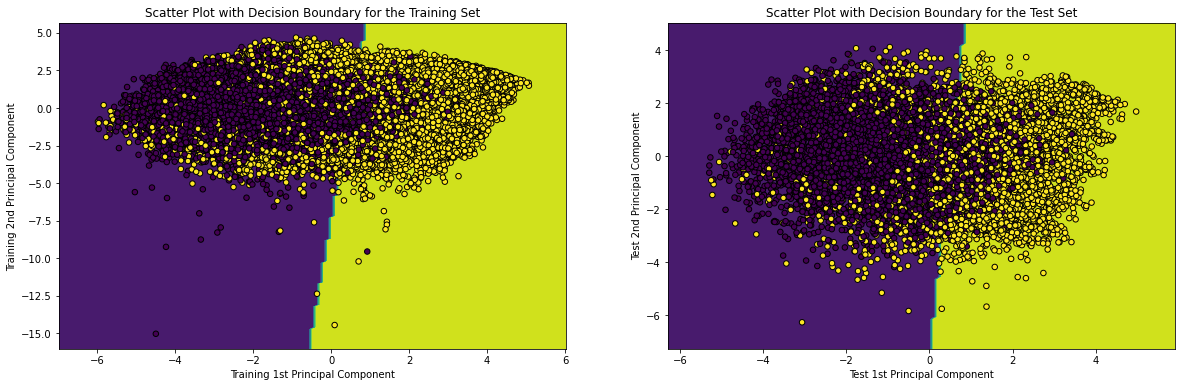

In [15]:
#X=X_train.iloc[:,:-1]

columns = X_train.columns
scalerx = StandardScaler()
X_train_scaled = scalerx.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = columns)

X_test_scaled = scalerx.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = columns)

pca = IncrementalPCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LogisticRegression(C = 10).fit(X_train_pca, y_train)

#X_test_pca = pca.transform(X_test_scaled)
#imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
#imputer = imputer.fit(X_train.head(10).iloc[:,  :-1])
#X = imputer.transform(X_train.head(10).iloc[:,  :-1])

plot_scatter(model,X_train_pca,y_train,X_test_pca,y_test,"Decision Boundary Analysis")